# ARMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from pmdarima import auto_arima
import datetime

palettename = "ch:start=.2,rot=-.3"
palette = sns.color_palette(palettename, 10)
palette = palette.as_hex()
sns.set_palette(palette.reverse())
col1 = palette[8]
col2 = palette[5]
col3 = palette[2]
cols = [col1, col2, col3]
palette

['#27213f',
 '#37355d',
 '#454b78',
 '#52628f',
 '#5f79a3',
 '#6d90b2',
 '#7da7c0',
 '#91bccc',
 '#a8d0d7',
 '#c3e2e3']

In [2]:
price_2022 = pd.read_csv('../Data/hourly_data_2022.csv')
price_2023 = pd.read_csv('../Data/hourly_data_2023.csv')
price = pd.concat([price_2022,price_2023]).reset_index().drop(columns={'index'})
price.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/hourly_data_2022.csv'

In [4]:
demand_2022 = pd.read_csv('../Data/PUB_Demand_2022.csv')
demand_2023 = pd.read_csv('../Data/PUB_Demand_2023.csv')
demand = pd.concat([demand_2022,demand_2023]).reset_index().drop(columns={'index'})
demand.head()

,Date,Hour,Market Demand,Ontario Demand
0,2022-01-01,1,15150,13543
1,2022-01-01,2,15344,13254
2,2022-01-01,3,14686,12683
3,2022-01-01,4,14400,12491
4,2022-01-01,5,14043,12493


In [9]:
df = pd.merge(price,demand,on=['Date','Hour'],how = 'left')
df = df[['Date','Hour','HOEP','Hour 1 Predispatch','Hour 2 Predispatch','Hour 3 Predispatch','Market Demand','Ontario Demand']]
date=pd.to_datetime(df['Date'])
hour=df['Hour']
hour = hour.replace(24,0)
hour=hour.apply(lambda x: datetime.time(x,0))
dt=date.apply(lambda x: str(x.date()))+' '+hour.apply(lambda x: str(x))
dt = pd.to_datetime(dt)
def adjusthour(x):
    if x.hour == 0:
        return x + datetime.timedelta(days=1)
    else:
        return x
dt = dt.apply(adjusthour)
df['Date']=dt
df.drop('Hour',axis=1,inplace=True)
df.rename(columns={'Date':'date','HOEP':'price','Hour 1 Predispatch':'1_hour_pred','Hour 2 Predispatch':'2_hour_pred','Hour 3 Predispatch':'3_hour_pred', 'Market Demand':'market_demand', 'Ontario Demand':'ontario_demand'},inplace=True)
df = df.set_index('date')
df

,price,1_hour_pred,2_hour_pred,3_hour_pred,market_demand,ontario_demand
date,,,,,,
2022-01-01 01:00:00,32.18,27.75,27.73,32.41,15150,13543
2022-01-01 02:00:00,59.04,23.23,28.62,32.41,15344,13254
2022-01-01 03:00:00,18.79,17.00,14.36,29.13,14686,12683
2022-01-01 04:00:00,15.78,18.00,17.20,14.39,14400,12491
2022-01-01 05:00:00,0.41,12.99,12.99,29.51,14043,12493
...,...,...,...,...,...,...
2023-01-16 20:00:00,14.39,36.07,37.53,39.73,20792,18522
2023-01-16 21:00:00,14.37,33.86,36.71,38.96,20440,18195
2023-01-16 22:00:00,12.95,35.12,35.41,35.77,19721,17536


<AxesSubplot: xlabel='date'>

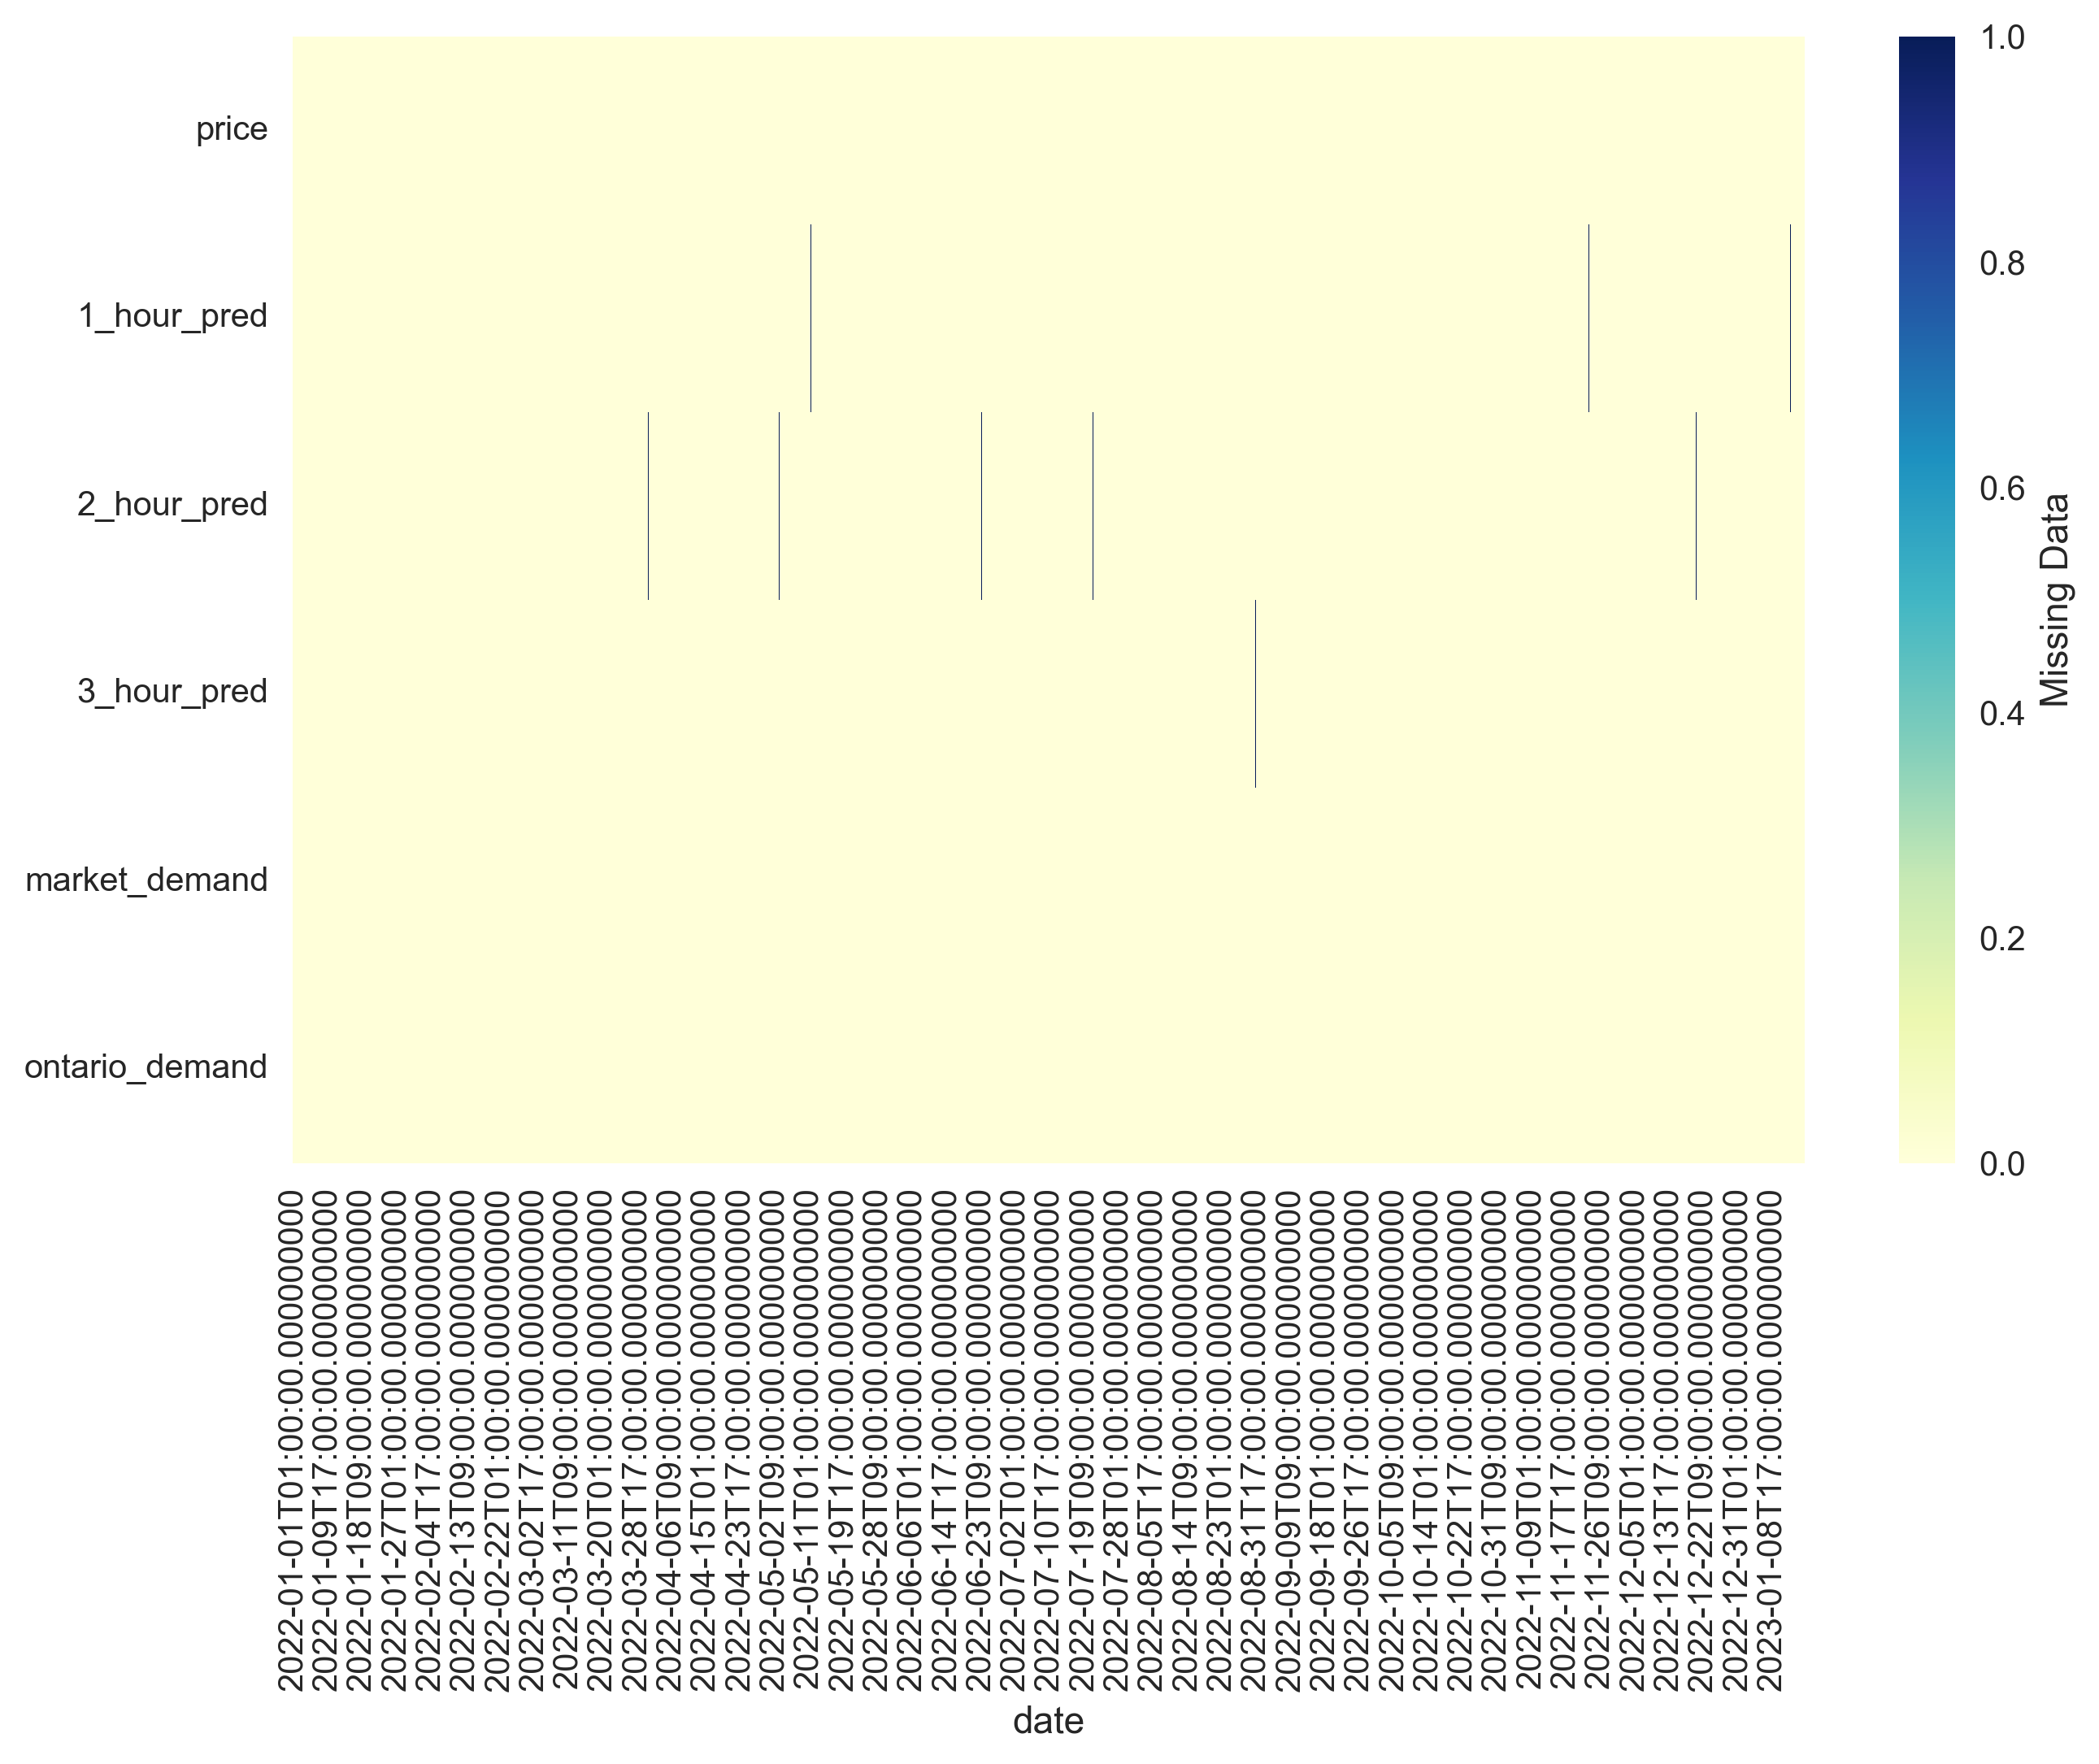

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

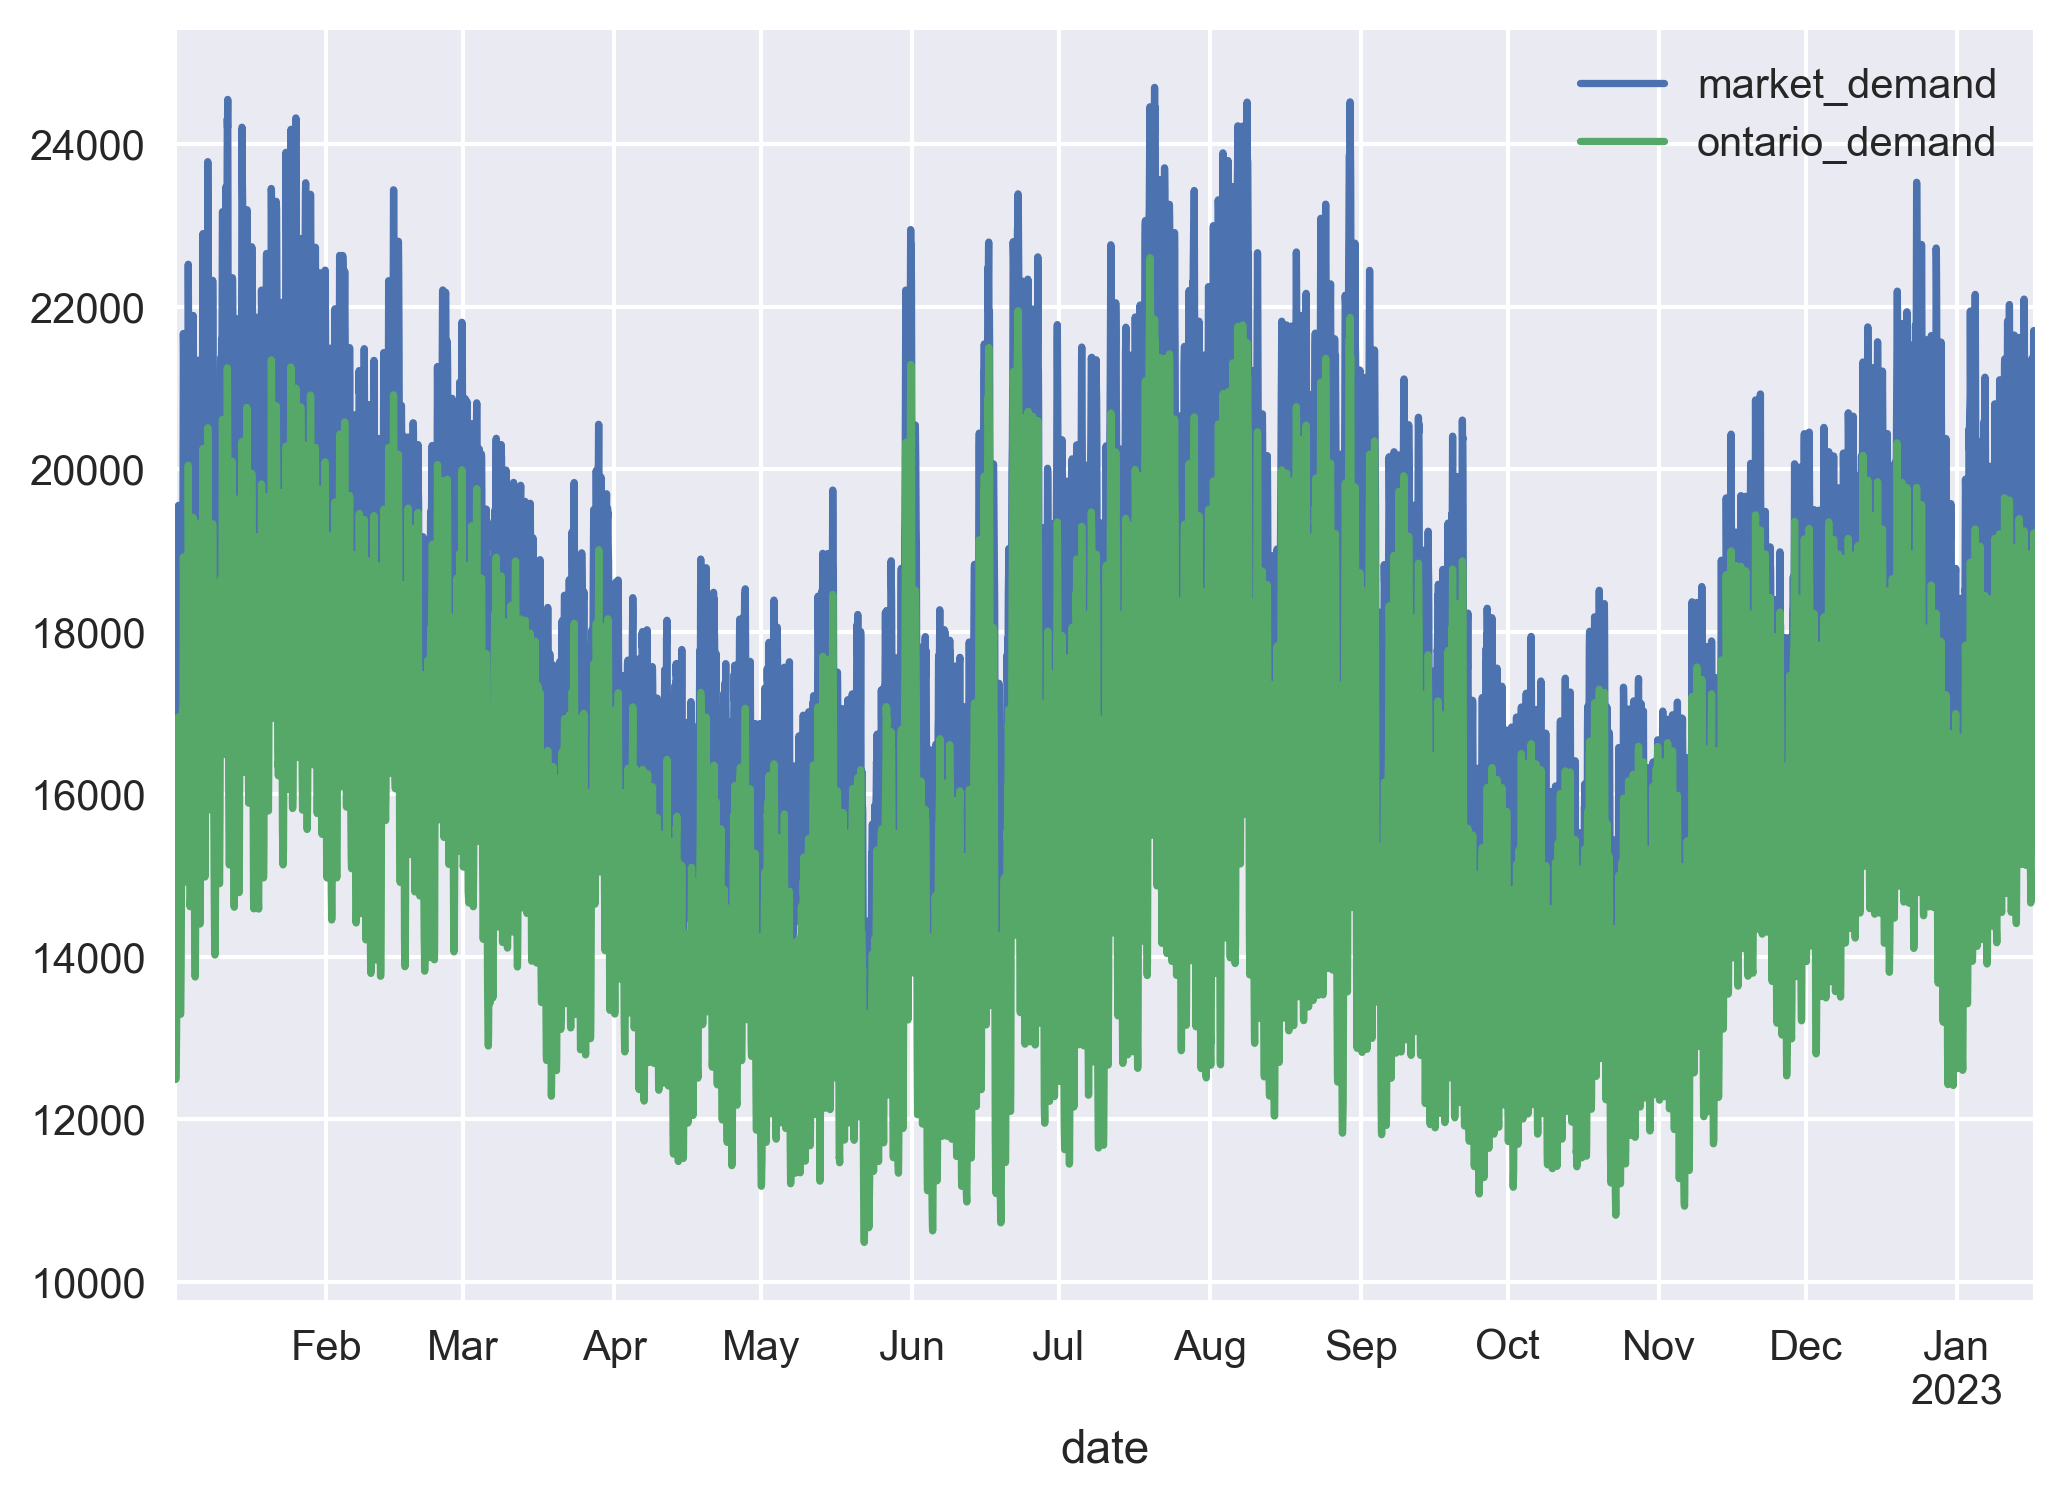

In [17]:
df[['market_demand', 'ontario_demand']].plot();

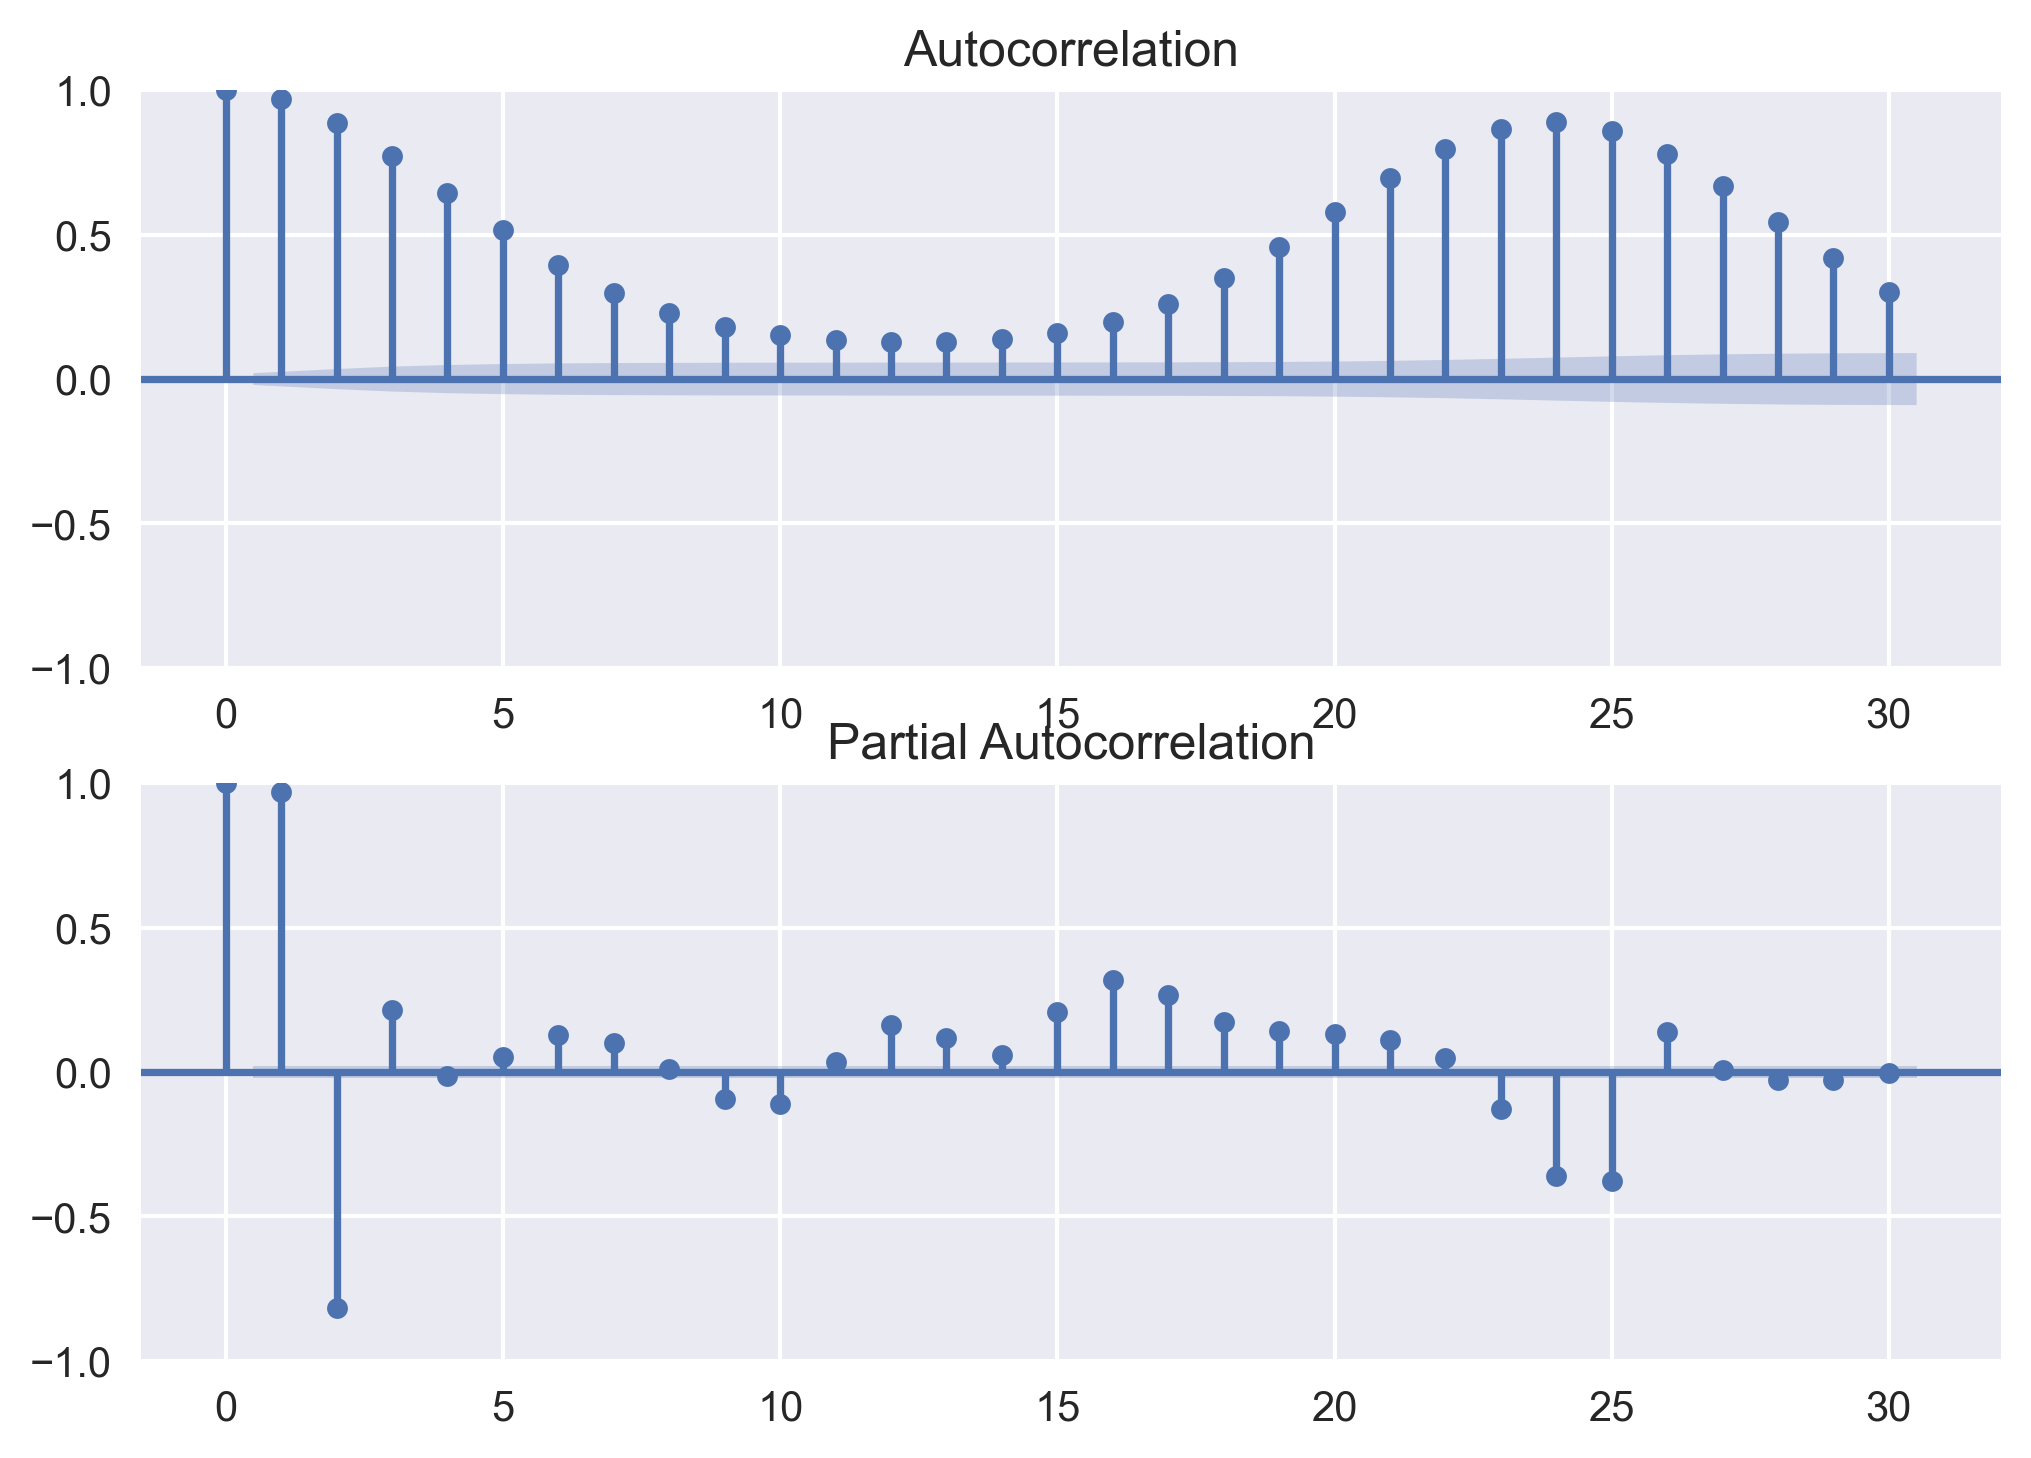

In [12]:
plt.figure()
plt.subplot(211)
plot_acf(df.ontario_demand, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(df.ontario_demand, ax=plt.gca(), lags = 30, method = 'ywm')
plt.show()

In [65]:
def loadfileCombine(startyear = 2012, stopyear = 2022):
    
    
    datafile = pd.DataFrame({'Date':[],'Hour':[],'Ontario Demand':[]}) # initialize empty file
    
    for year in range(startyear, stopyear+1):
        filepath = "http://reports.ieso.ca/public/Demand/PUB_Demand_{}.csv".format(year)
        df =  pd.read_csv(filepath, skiprows= [0,1,2], usecols = lambda x: x in ['Date','Hour','Ontario Demand'],parse_dates=["Date"]) # skip rows 0,1,2
        datafile = pd.concat([datafile,df], axis = 0)
        
    
    # adding extra attributes
    datafile["Year"] = datafile["Date"].dt.year
    datafile["Month"] = datafile["Date"].dt.month
    datafile["timestamp"] = datafile["Date"].add(pd.to_timedelta(datafile.Hour - 1, unit="h")) # create timestamp variable from Date and Hour
    
    
    datafile.index = range(len(datafile)) # to have correct index
    datafile = datafile.rename(columns={"Ontario Demand": "load"})
    
    # merging the two files
    
    data = pd.DataFrame(datafile)
    
    data = data[["timestamp","Date","load","Year","Month","Hour"]]
    
    # save to csv
    data.to_csv("loadDemand.csv",index=False) #, index=False
    return data

In [66]:
loadDemand=loadfileCombine()
loadDemand.head()

,timestamp,Date,load,Year,Month,Hour
0,2012-01-01 00:00:00,2012-01-01,13710.0,2012,1,1.0
1,2012-01-01 01:00:00,2012-01-01,13285.0,2012,1,2.0
2,2012-01-01 02:00:00,2012-01-01,12905.0,2012,1,3.0
3,2012-01-01 03:00:00,2012-01-01,12608.0,2012,1,4.0
4,2012-01-01 04:00:00,2012-01-01,12439.0,2012,1,5.0


In [67]:
df = loadDemand[['timestamp', 'load']].set_index("timestamp")
y = df.load
y

timestamp
2012-01-01 00:00:00    13710.0
2012-01-01 01:00:00    13285.0
2012-01-01 02:00:00    12905.0
2012-01-01 03:00:00    12608.0
2012-01-01 04:00:00    12439.0
                        ...   
2022-12-31 19:00:00    15834.0
2022-12-31 20:00:00    15465.0
2022-12-31 21:00:00    15086.0
2022-12-31 22:00:00    14453.0
2022-12-31 23:00:00    13965.0
Name: load, Length: 96432, dtype: float64

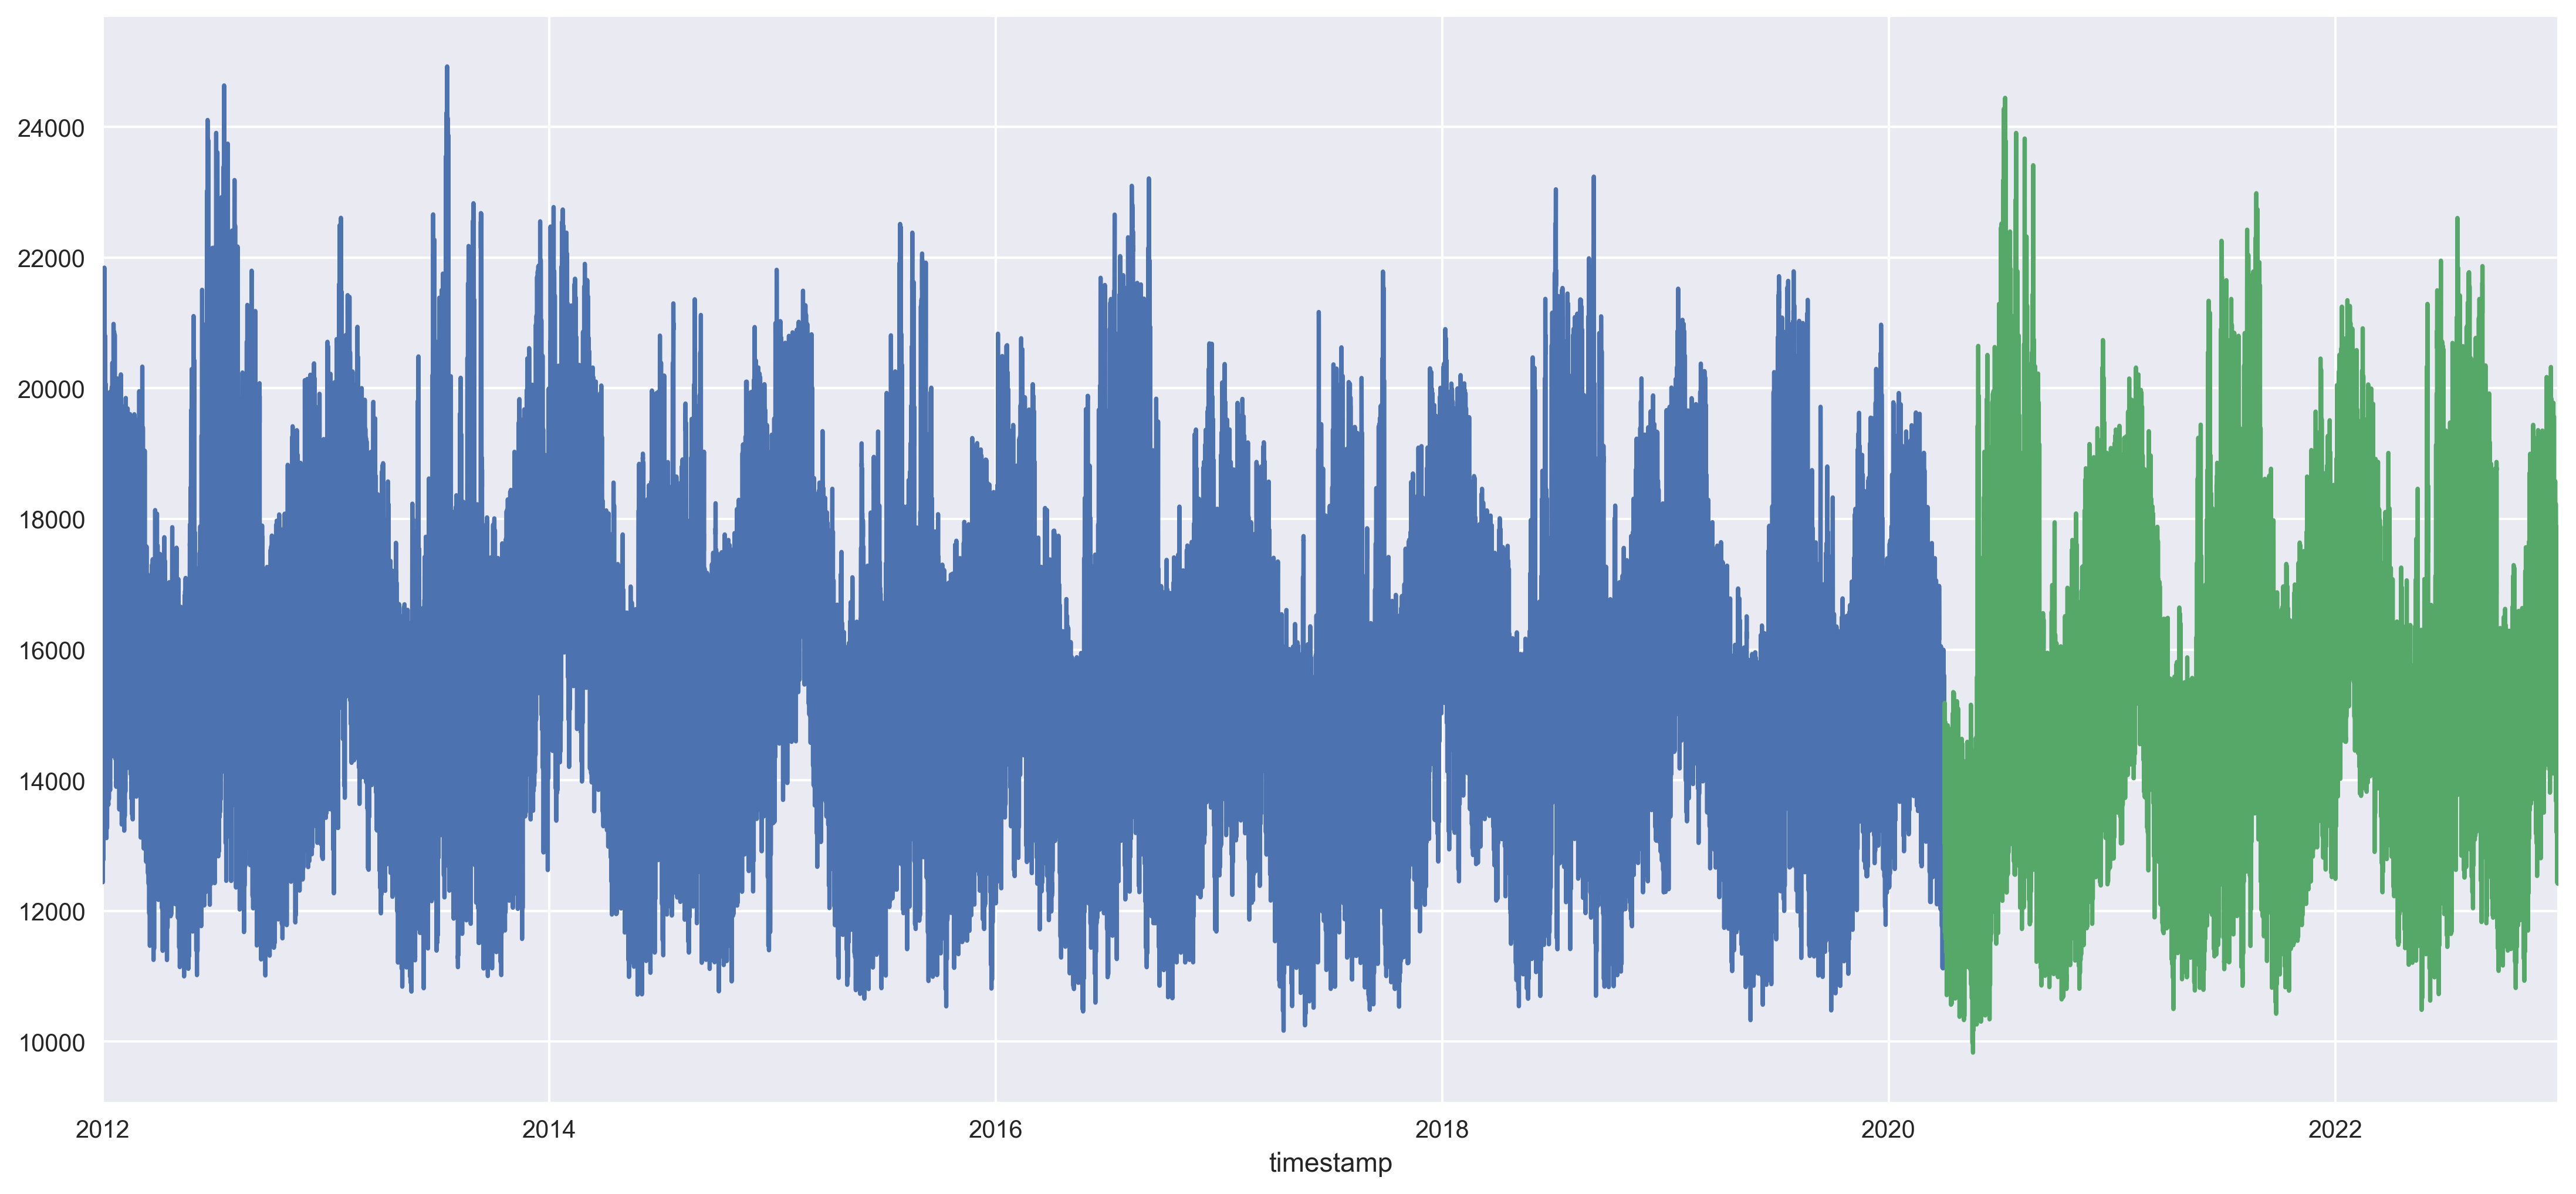

In [68]:
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]
train.plot()
valid.plot();

In [71]:
model = auto_arima(train, start_p=0, start_q=0, test="adf", trace=True, seasonal=24,d= None, max_d=4, max_p=4)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1604280.789, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1505776.487, Time=2.56 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1077777.745, Time=2.00 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1052085.149, Time=1.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=13.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1051109.305, Time=4.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1057122.663, Time=3.49 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=10.90 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1051124.053, Time=6.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1053190.310, Time=4.02 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=12.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1044995.763, Time=7.28 sec
 ARIMA(1,0,2)(0,0,0)[0] inte

KeyboardInterrupt: 

In [73]:
model

ARIMA(order=(3, 0, 5), scoring_args={}, suppress_warnings=True)

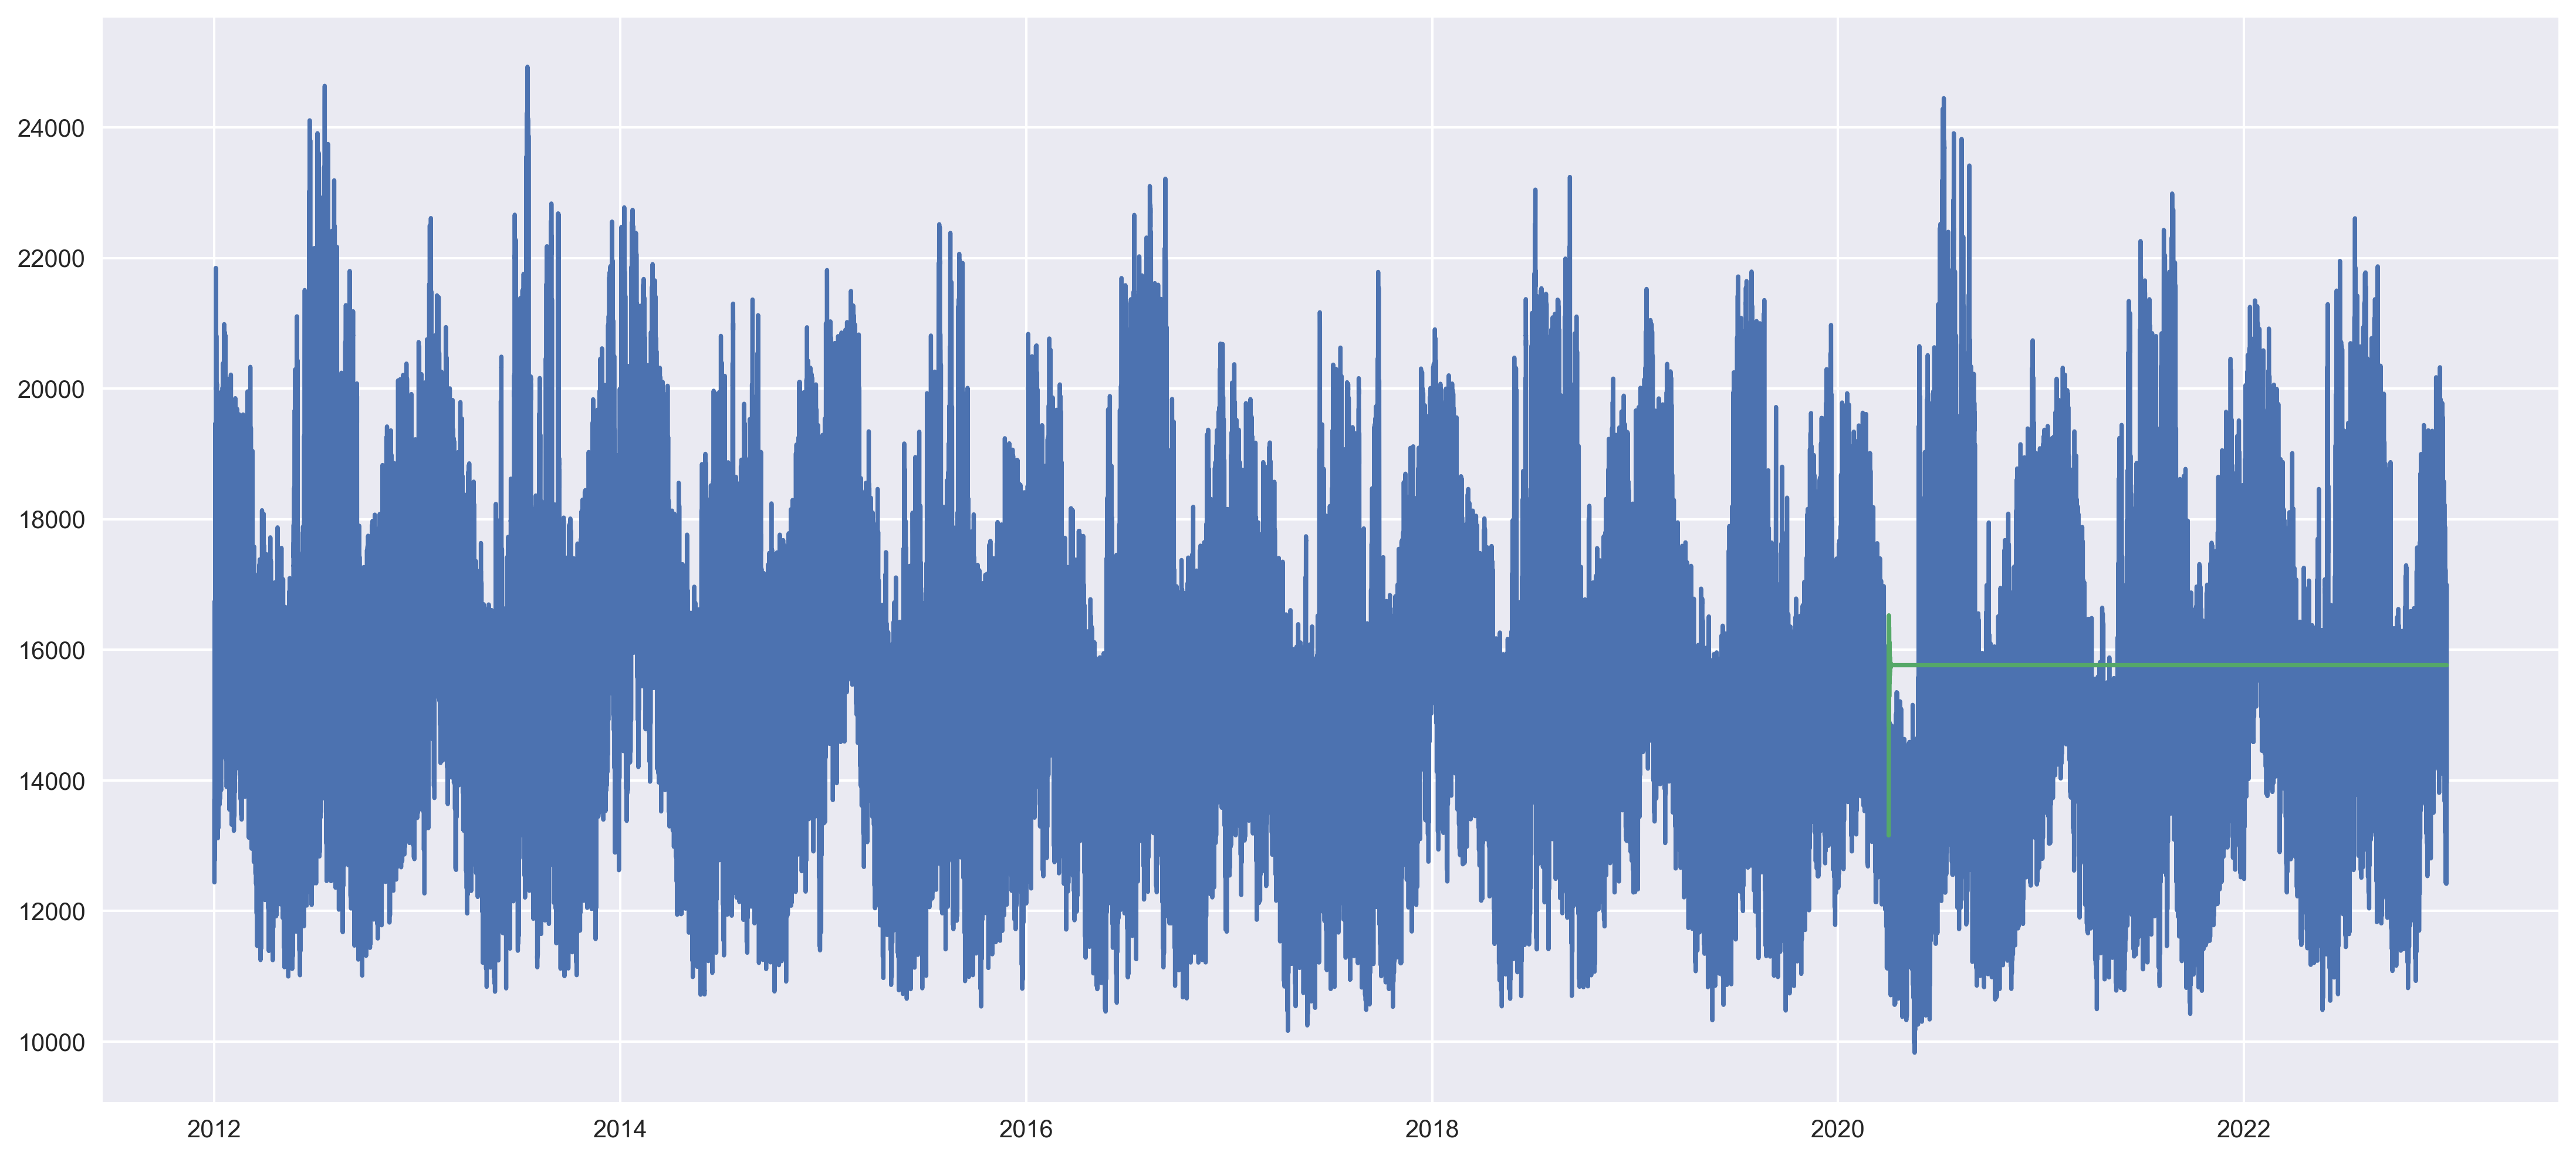

In [72]:
start_index = valid.index.min()
end_index = valid.index.max()

pred = model.predict()
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

# Plot the predictions for validation set
plt.plot(y, label='Train')
plt.plot(forecast, label='Prediction')
plt.show()